In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [2]:
tf.__version__

'2.1.0'

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [6]:
sys.path.append(os.getcwd())

In [7]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [8]:
crossvals, encoders = prepare_crossval_experiment(nsplits=10)

{'item_id', 'user_id', 'rating', 'split', 'timestamp'}
Processing cv 0
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 64083
Dtype: DataType.TEST shape: 5454
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65267
Dtype: DataType.TEST shape: 4732
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65928
Dtype: DataType.TEST shape: 4350
Dtype: DataType.VALID shape: 2903
N train ids: 18301
N train val ids: 2034
Processing cv 3
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65835
Dtype: DataType.TEST shape: 4353
Dtype: DataType.VALID shape: 2993
N train ids: 18301
N train val ids: 2034
Processing cv 4
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 66018
Dtype: DataType.TEST shape: 4293


/anaconda/envs/py37_default/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [11]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [9]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [10]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [11]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train[:, 0].astype('int32'),
        exd.Xfeatures_train[:, 1].astype('int32'),
        exd.Xfeatures_train[:, 2].astype('int32'),
        exd.Xfeatures_train[:, 3].astype('int32'),
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid[:, 0].astype('int32'),
        exd.Xfeatures_valid[:, 1].astype('int32'),
        exd.Xfeatures_valid[:, 2].astype('int32'),
        exd.Xfeatures_valid[:, 3].astype('int32'),
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    # TODO: investigat emissing enties in matrices below - why there are so many nan's
    x_test_reconstruction = [
        exd.Xhidden_test.user_id.to_numpy(dtype='int32'),
        exd.Xhidden_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test[:, 0].astype('int32'),
        exd.Xfeatures_test[:, 1].astype('int32'),
        exd.Xfeatures_test[:, 2].astype('int32'),
        exd.Xfeatures_test[:, 3].astype('int32'),
    ]
    y_test_reconstruction = exd.Xhidden_test.rating
    
    x_test_pred = [
        exd.test_records_selected.user_id.to_numpy(dtype='int32'),
        exd.test_records_selected.item_id.to_numpy(dtype='int32'),
        exd.test_records_selected.iloc[:, :-5].to_numpy(dtype='int32')
    ]
    
    return x, y, x_val, y_val, x_test_reconstruction

In [12]:
exd = crossvals[0]

In [13]:
nulls = []
for exd in crossvals:
    null_i = exd.test_records_selected.iloc[:, :-5].isna().sum(axis=0).any()
    nulls.append(null_i)
nulls

[False, False, False, False, False, False, False, False, False, False]

In [14]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [20]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer=optimizer, metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [32]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 12s 188us/sample - loss: 2.7959 - mse_masked: 2.7955 - mae: 1.2756 - mape_masked: 0.4327 - val_loss: 1.4413 - val_mse_masked: 1.4418 - val_mae: 0.9269 - val_mape_masked: 0.4105
Epoch 2/15
64083/64083 [==============================] - 11s 168us/sample - loss: 1.2329 - mse_masked: 1.2329 - mae: 0.8386 - mape_masked: 0.3572 - val_loss: 1.4097 - val_mse_masked: 1.4103 - val_mae: 0.9224 - val_mape_masked: 0.4026
Epoch 3/15
64083/64083 [==============================] - 11s 167us/sample - loss: 0.9690 - mse_masked: 0.9692 - mae: 0.7316 - mape_masked: 0.3036 - val_loss: 1.4089 - val_mse_masked: 1.4094 - val_mae: 0.9365 - val_mape_masked: 0.3997
Epoch 4/15
64083/64083 [==============================] - 11s 168us/sample - loss: 0.8195 - mse_masked: 0.8195 - mae: 0.6736 - mape_masked: 0.2702 - val_loss: 1.4224 - val_mse_masked: 1.4229 - val_mae: 0.9369 - val_mape_masked: 0.4016
Epoch 5/15


In [33]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

## Deep recommender

In [15]:
exd = crossvals[0]

In [16]:
exd.Xfeatures_train.shape

(64083, 5)

In [17]:
for k, e in encoders.items():
    print(f"{k}: {e.classes_.shape[0]}")

user_attr: 3
model_attr: 3
brand: 51
category: 10
year: 20


In [19]:
exd.nuser**0.25, exd.nitems**(0.25)

(11.941559425478882, 8.998284832121543)

In [20]:
def autorec_multiple_embeddings(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    
    dim_embed = 64
    #dim_embed_userattr = 3
    #dim_embed_modelattr = 3
    dim_embed_brand = 16
    dim_embed_category = 4
    #dim_embed_year = 4
    
    #uitem_common_dense = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))
    
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())
    
    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, 64, embeddings_initializer='glorot_normal')(user_input)
    u = krs.layers.Flatten()(u)
    #u = uitem_common_dense(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='glorot_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, 64, embeddings_initializer='glorot_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    #i = uitem_common_dense(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='glorot_normal',)(item_input))
    
    uattr_input = krs.Input(shape=(1, ), name='userattr_input', dtype='float32')
  #  uattr = krs.layers.Embedding(4, dim_embed_userattr, embeddings_initializer='he_normal',)(uattr_input)
   # uattr = krs.layers.Flatten()(uattr)
    
    mattr_input = krs.Input(shape=(1, ), name='modelattr_input', dtype='float32')
    #mattr = krs.layers.Embedding(4, dim_embed_modelattr, embeddings_initializer='he_normal',)(mattr_input)
    #mattr = krs.layers.Flatten()(mattr)
    """
    gender_emb = krs.layers.Embedding(4, 3, embeddings_initializer='glorot_normal',)
    uattr_emb = gender_emb(uattr_input)
    uattr_emb = krs.layers.Flatten()(uattr_emb)
    
    mattr_emb = gender_emb(mattr_input)
    mattr_emb = krs.layers.Flatten()(mattr_emb)
    """
    
    brand_input = krs.Input(shape=(1, ), name='brand_input', dtype='int32')
    br = krs.layers.Embedding(52, dim_embed_brand, embeddings_initializer='he_normal',)(brand_input)
    br = krs.layers.Flatten()(br)
    
    cat_input = krs.Input(shape=(1, ), name='cat_input', dtype='int32')
    cat =  krs.layers.Embedding(11, dim_embed_category, embeddings_initializer='he_normal',)(cat_input)
    cat = krs.layers.Flatten()(cat)
    
    all_features = krs.layers.Concatenate(axis=1)([u, u_bias, i, i_bias, uattr_input, mattr_input, br, cat])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(64, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(32, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    drop3 = krs.layers.Dropout(rate=0.2)(d2)
    d3 =  krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop3)
    drop4 = krs.layers.Dropout(rate=0.2)(d3)
    out = krs.layers.Dense(1, activation='relu')(drop4)
    #out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, uattr_input, mattr_input, brand_input, cat_input], outputs=out, *args, **kwargs)

    model.compile(loss='mse', optimizer=optimizer, metrics=metrics)
    #print(model.summary())
    return model

In [89]:
def autorec_two_towers(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    
    dim_embed = 64
    #dim_embed_userattr = 3
    #dim_embed_modelattr = 3
    dim_embed_brand = 16
    dim_embed_category = 4
    #dim_embed_year = 4
    
    #uitem_common_dense = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))
    
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())
    
    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, 64, embeddings_initializer='glorot_normal')(user_input)
    u = krs.layers.Flatten()(u)
    #u = uitem_common_dense(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='glorot_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, 64, embeddings_initializer='glorot_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    #i = uitem_common_dense(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='glorot_normal',)(item_input))
    
    uattr_input = krs.Input(shape=(1, ), name='userattr_input', dtype='float32')
  #  uattr = krs.layers.Embedding(4, dim_embed_userattr, embeddings_initializer='he_normal',)(uattr_input)
   # uattr = krs.layers.Flatten()(uattr)
    
    mattr_input = krs.Input(shape=(1, ), name='modelattr_input', dtype='float32')
    #mattr = krs.layers.Embedding(4, dim_embed_modelattr, embeddings_initializer='he_normal',)(mattr_input)
    #mattr = krs.layers.Flatten()(mattr)
    """
    gender_emb = krs.layers.Embedding(4, 3, embeddings_initializer='glorot_normal',)
    uattr_emb = gender_emb(uattr_input)
    uattr_emb = krs.layers.Flatten()(uattr_emb)
    
    mattr_emb = gender_emb(mattr_input)
    mattr_emb = krs.layers.Flatten()(mattr_emb)
    """
    
    brand_input = krs.Input(shape=(1, ), name='brand_input', dtype='int32')
    br = krs.layers.Embedding(52, dim_embed_brand, embeddings_initializer='he_normal',)(brand_input)
    br = krs.layers.Flatten()(br)
    
    cat_input = krs.Input(shape=(1, ), name='cat_input', dtype='int32')
    cat =  krs.layers.Embedding(11, dim_embed_category, embeddings_initializer='he_normal',)(cat_input)
    cat = krs.layers.Flatten()(cat)
    
    i_features = krs.layers.Concatenate(axis=1)([i, i_bias, mattr_input, br, cat])
    i_drop1 = krs.layers.Dropout(rate=0.2)(i_features)
    i_dense = krs.layers.Dense(32,  activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(i_drop1)
    i_drop2 = krs.layers.Dropout(rate=0.2)(i_dense)
    i_dense2 = krs.layers.Dense(16,  activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(i_drop2)
    
    u_features = krs.layers.Concatenate(axis=1)([u, u_bias, uattr_input, mattr_input, br, cat])
    u_drop1 = krs.layers.Dropout(rate=0.2)(u_features)
    u_dense = krs.layers.Dense(32,  activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(u_drop1)
    u_drop2 = krs.layers.Dropout(rate=0.2)(u_dense)
    u_dense2 = krs.layers.Dense(16,  activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(u_drop2)
    
    all_features = krs.layers.Concatenate(axis=1)([i_dense2, u_dense2])
    all_drop1 = krs.layers.Dropout(rate=0.2)(all_features)
    all_dense1 = krs.layers.Dense(8,  activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(all_drop1)
    all_drop2 = krs.layers.Dropout(rate=0.2)(all_dense1)
    out = krs.layers.Dense(1, activation='relu')(all_drop2)
    
    model = krs.Model(inputs=[user_input, item_input, uattr_input, mattr_input, brand_input, cat_input], outputs=out, *args, **kwargs)

    model.compile(loss='mse', optimizer=optimizer, metrics=metrics)
    #print(model.summary())
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [90]:
preselect_exd = crossvals[0]

In [91]:
krs.backend.clear_session()

In [92]:
import gc
gc.collect()

120

In [94]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer =  tf.keras.optimizers.Adagrad() #tf.keras.optimizers.RMSprop(learning_rate=0.005, momentum=0.9) #tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(exd, autorec_two_towers, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [lr_schedule]})

Train on 66618 samples, validate on 2632 samples
Epoch 1/15
66618/66618 [==============================] - 20s 297us/sample - loss: 7.3406 - mse_masked: 7.3250 - mape_masked: 0.6106 - mae: 2.2733 - val_loss: 2.3598 - val_mse_masked: 2.3423 - val_mape_masked: 0.4219 - val_mae: 1.3254
Epoch 2/15
66618/66618 [==============================] - 18s 263us/sample - loss: 3.8498 - mse_masked: 3.8343 - mape_masked: 0.5055 - mae: 1.5958 - val_loss: 1.9686 - val_mse_masked: 1.9513 - val_mape_masked: 0.4049 - val_mae: 1.2213
Epoch 3/15
66618/66618 [==============================] - 18s 265us/sample - loss: 3.4467 - mse_masked: 3.4315 - mape_masked: 0.4880 - mae: 1.5010 - val_loss: 1.7939 - val_mse_masked: 1.7769 - val_mape_masked: 0.3964 - val_mae: 1.1727
Epoch 4/15
66618/66618 [==============================] - 18s 273us/sample - loss: 3.2270 - mse_masked: 3.2116 - mape_masked: 0.4798 - mae: 1.4485 - val_loss: 1.7364 - val_mse_masked: 1.7196 - val_mape_masked: 0.3939 - val_mae: 1.1661
Epoch 5/15


In [95]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

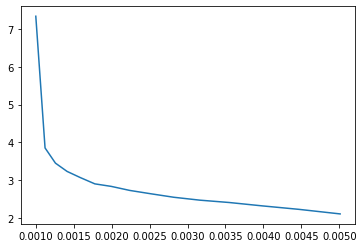

In [96]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

### Deep autorec crossval

In [98]:
lr = 0.005

In [99]:
import gc
tf.keras.backend.clear_session()
gc.collect()

autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.002, patience=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) #tf.keras.optimizers.RMSprop(learning_rate=lr, momentum=0.9)
#tf.keras.optimizers.Adam() 
#tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
    
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, autorec_two_towers, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 59s 925us/sample - loss: 1.6885 - mse_masked: 1.6731 - mape_masked: 0.3999 - mae: 1.0053 - val_loss: 1.4450 - val_mse_masked: 1.4315 - val_mape_masked: 0.4010 - val_mae: 0.9436
Epoch 2/15
64083/64083 [==============================] - 57s 886us/sample - loss: 1.1648 - mse_masked: 1.1485 - mape_masked: 0.3396 - mae: 0.7962 - val_loss: 1.4746 - val_mse_masked: 1.4584 - val_mape_masked: 0.3940 - val_mae: 1.0124
Epoch 3/15
64083/64083 [==============================] - 57s 894us/sample - loss: 1.0326 - mse_masked: 1.0153 - mape_masked: 0.3101 - mae: 0.7358 - val_loss: 1.4556 - val_mse_masked: 1.4384 - val_mape_masked: 0.3958 - val_mae: 0.9714
Epoch 4/15
64083/64083 [==============================] - 59s 920us/sample - loss: 0.9786 - mse_masked: 0.9624 - mape_masked: 0.2982 - mae: 0.7126 - val_loss: 1.5147 - val_mse_masked: 1.4970 - val_mape_masked: 0.3922 - val_mae: 1.0339
Epoch 5/15


KeyboardInterrupt: 

In [84]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [90]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

# Compare two models

In [ ]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [85]:
autorec_results[["autorec_mape", "autorec_mse"]]

,autorec_mape,autorec_mse
0,0.391535,1.375318
1,0.432302,1.523024
2,0.413737,1.456458
3,0.404434,1.426201
4,0.363036,1.257392
5,0.352815,1.249524
6,0.394572,1.391518
7,0.415696,1.473378
8,0.411954,1.463683
9,0.411497,1.446799


In [86]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)
colab_res[["colab_mape", "colab_mse"]]

,colab_mape,colab_mse
0,0.381724,1.341046
1,0.417127,1.451853
2,0.398994,1.405102
3,0.395755,1.407544
4,0.358347,1.268155
5,0.343120,1.203991
6,0.387410,1.395020
7,0.404051,1.440887
8,0.405730,1.447349
9,0.401230,1.412892


In [87]:
autorec_results.autorec_mse.mean(), colab_res.colab_mse.mean()

(1.4063294768333434, 1.3773839950561524)

In [88]:
autorec_results.autorec_mape.mean(), colab_res.colab_mape.mean()

(0.3991576939821243, 0.3893488645553589)

In [43]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative='two-sided')

WilcoxonResult(statistic=19.0, pvalue=0.4148230671847747)

In [43]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=0.0, pvalue=0.005921537024148708)

In [46]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse, use_continuity=True)

MannwhitneyuResult(statistic=29.0, pvalue=0.06061225150645831)

In [44]:
st.mannwhitneyu(autorec_results.autorec_mape, colab_res.colab_mape, use_continuity=True)

MannwhitneyuResult(statistic=31.0, pvalue=0.08098620524006306)

In [46]:
st.kruskal(autorec_results.autorec_mape, colab_res.colab_mape)

KruskalResult(statistic=2.0628571428571405, pvalue=0.15092695006671242)

In [87]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=6.504160376112249, pvalue=8.209933725459241e-06)

In [88]:
st.ttest_ind(autorec_results.autorec_mape, colab_res.colab_mape, equal_var=False)

Ttest_indResult(statistic=-0.6909034172275881, pvalue=0.49870164935874917)